In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv(r"data/train.csv")
test = pd.read_csv(r"data/test.csv")
sample_submission = pd.read_csv(r"data/sample_submission.csv")

sample_submission.head()

target_col = 'Listening_Time_minutes'

# Handle missing values

In [3]:
# Check for missing values
print("\nMissing values in training set:")
train.isnull().sum()


Missing values in training set:


id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

- separete the columns

In [4]:
numerical_cols = train[test.columns].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train[test.columns].select_dtypes(include=['object']).columns

In [5]:

for df in [train, test]:
    # Fill numerical columns with median grouped by Podcast_Name
    for col in numerical_cols:
        df[col] = df.groupby('Podcast_Name')[col].transform(lambda x: x.fillna(x.median()))

    # Fill categorical columns with mode grouped by Podcast_Name 
    for col in categorical_cols:
        if col in ['Podcast_Name', 'Episode_Title']:
            continue
        df[col] = df.groupby('Podcast_Name')[col].transform(lambda x: x.fillna(x.mode()[0]))

In [6]:
# Check for missing values
print("\nMissing values in training set:")
train.isnull().sum()


Missing values in training set:


id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

In [7]:
# for col in categorical_cols:
#     one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#     # Fit and transform the data
#     encoded_data = one_hot_encoder.fit_transform(train[[col]])  # Note double brackets to keep it as 2D
#     # Convert to DataFrame
#     encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out([col]))
#     # Concatenate with original DataFrame
#     train = pd.concat([train, encoded_df], axis=1)

In [8]:
# train = train.drop(categorical_cols, axis=1)

# Feature Engineering

In [9]:
numerical_cols = train[test.columns].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train[test.columns].select_dtypes(include=['object']).columns

In [10]:
train.groupby('Publication_Day')[target_col].mean().sort_values()

Publication_Day
Sunday       44.817398
Thursday     44.869706
Friday       45.206591
Saturday     45.326775
Wednesday    45.807177
Monday       45.969630
Tuesday      46.131411
Name: Listening_Time_minutes, dtype: float64

- map in 3 bins => map({'Saturday': 1, 'Sunday': 0, 'Monday': 2, 'Tuesday': 2, 'Wednesday': 2, 'Thursday': 0, 'Friday': 1})

In [11]:
def get_bins(data):
    # Calculate quartile values
    q1 = data.quantile(0.25)
    q2 = data.quantile(0.50) 
    q3 = data.quantile(0.75)

    # Create bins using quartiles
    bins = [-np.inf, q1, q2, q3, np.inf]
    return bins

In [12]:
def label_encoding(df_train, df_test, col):
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [13]:
def transformation(df):
    thresholds = {
        'high_popular_host_bins': get_bins(df['Host_Popularity_percentage']),
        'high_popular_guest_bins': get_bins(df['Guest_Popularity_percentage']),
        'episode_length_bins': get_bins(df['Episode_Length_minutes']),
        'ads_bins': get_bins(df['Number_of_Ads']),
    }
    return thresholds


In [14]:

def feature_engineering(df, train_df=None):
    if train_df is not None:
        transform = transformation(train_df)
    else:
        transform = transformation(df)
    
    # Features that don't depend on training data
    df['Weekend_Bin'] = df['Publication_Day'].map({'Saturday': 1, 'Sunday': 0, 'Monday': 2, 'Tuesday': 2, 'Wednesday': 2, 'Thursday': 0, 'Friday': 1}).astype('category')
    df['Guest_Host_Popularity_Ratio'] = df['Guest_Popularity_percentage'] / (df['Host_Popularity_percentage'])
    df['Ads_Per_Minute'] = (df['Number_of_Ads'] / df['Episode_Length_minutes']).fillna(0)
    # df['Host_Guest_Synergy'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']
    # df['Host_Guest_Popularity_Sum'] = df['Guest_Popularity_percentage'] + df['Host_Popularity_percentage']

    df['Publication_Day'] = df['Publication_Day'].map({'Saturday': 0, 'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6})
    df['Publication_Time'] = df['Publication_Time'].map({'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3})
    df['Episode_Number'] = df['Episode_Title'].str.extract('(\d+)').astype(int)

    df['Publication_Time_sin'] = np.sin(df['Publication_Time'] * (2 * np.pi / 24))
    df['Publication_Time_cos'] = np.cos(df['Publication_Time'] * (2 * np.pi / 24))
    df['Publication_Day_sin'] = np.sin(df['Publication_Day'] * (2 * np.pi / 7))
    df['Publication_Day_cos'] = np.cos(df['Publication_Day'] * (2 * np.pi / 7))
    df['Episode_Number_sin'] = np.cos(df['Episode_Number'] * (2 * np.pi / 10))

    # Features that depend on training data thresholds
    df['high_popular_host_bins'] = pd.cut(df['Episode_Length_minutes'],
                                    bins=transform['high_popular_host_bins'],
                                    labels=[0, 1, 2, 3]).astype('category')
    df['high_popular_guest_bins'] = pd.cut(df['Guest_Popularity_percentage'],
                                    bins=transform['high_popular_guest_bins'],
                                    labels=[0, 1, 2, 3]).astype('category')
    df['episode_length_bins'] = pd.cut(df['Episode_Length_minutes'],
                                    bins=transform['episode_length_bins'],
                                    labels=[0, 1, 2, 3]).astype('category')
    df['ads_bins'] = pd.cut(df['Number_of_Ads'],
                                    bins=transform['ads_bins'],
                                    labels=[0, 1, 2, 3]).astype('category')
    
    df['Episode_Number'] = df['Episode_Number'].astype('category')
    df['Podcast_Name'] = df['Podcast_Name'].astype('category')
    df['Publication_Day'] = df['Publication_Day'].astype('category')
    df['Publication_Time'] = df['Publication_Time'].astype('category')
    
    return df

In [15]:
df_train = feature_engineering(train, train_df=None)
df_test = feature_engineering(test, train_df=train)

In [16]:
for df in [df_train, df_test]:
    df.drop(columns=['Episode_Title'], inplace=True) # must drop 
    # df.drop(columns=['Episode_Title', 'Number_of_Ads', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage'], inplace=True)

In [17]:
df_test.select_dtypes(include=['object', 'string']).columns, df_train.select_dtypes(include=['object', 'string']).columns

(Index(['Genre', 'Episode_Sentiment'], dtype='object'),
 Index(['Genre', 'Episode_Sentiment'], dtype='object'))

In [18]:
cols = df_train.select_dtypes(include=['object', 'string']).columns

for col in cols:
    label_encoding(df_train, df_test, col)

In [19]:
# df_train['Genre'] = df_train['Genre'].astype('category')
# df_train['Episode_Sentiment'] = df_train['Episode_Sentiment'].astype('category')

# df_test['Genre'] = df_test['Genre'].astype('category')
# df_test['Episode_Sentiment'] = df_test['Episode_Sentiment'].astype('category')

In [20]:
df_train.select_dtypes(include=['object', 'category']).columns

Index(['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time',
       'Episode_Sentiment', 'Weekend_Bin', 'Episode_Number',
       'high_popular_host_bins', 'high_popular_guest_bins',
       'episode_length_bins', 'ads_bins'],
      dtype='object')

In [21]:
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop(['Podcast_Name', 'Episode_Number', 'Publication_Day'])

df_train = pd.get_dummies(df_train, columns=categorical_cols)
df_test = pd.get_dummies(df_test, columns=categorical_cols)

# Feature Importance

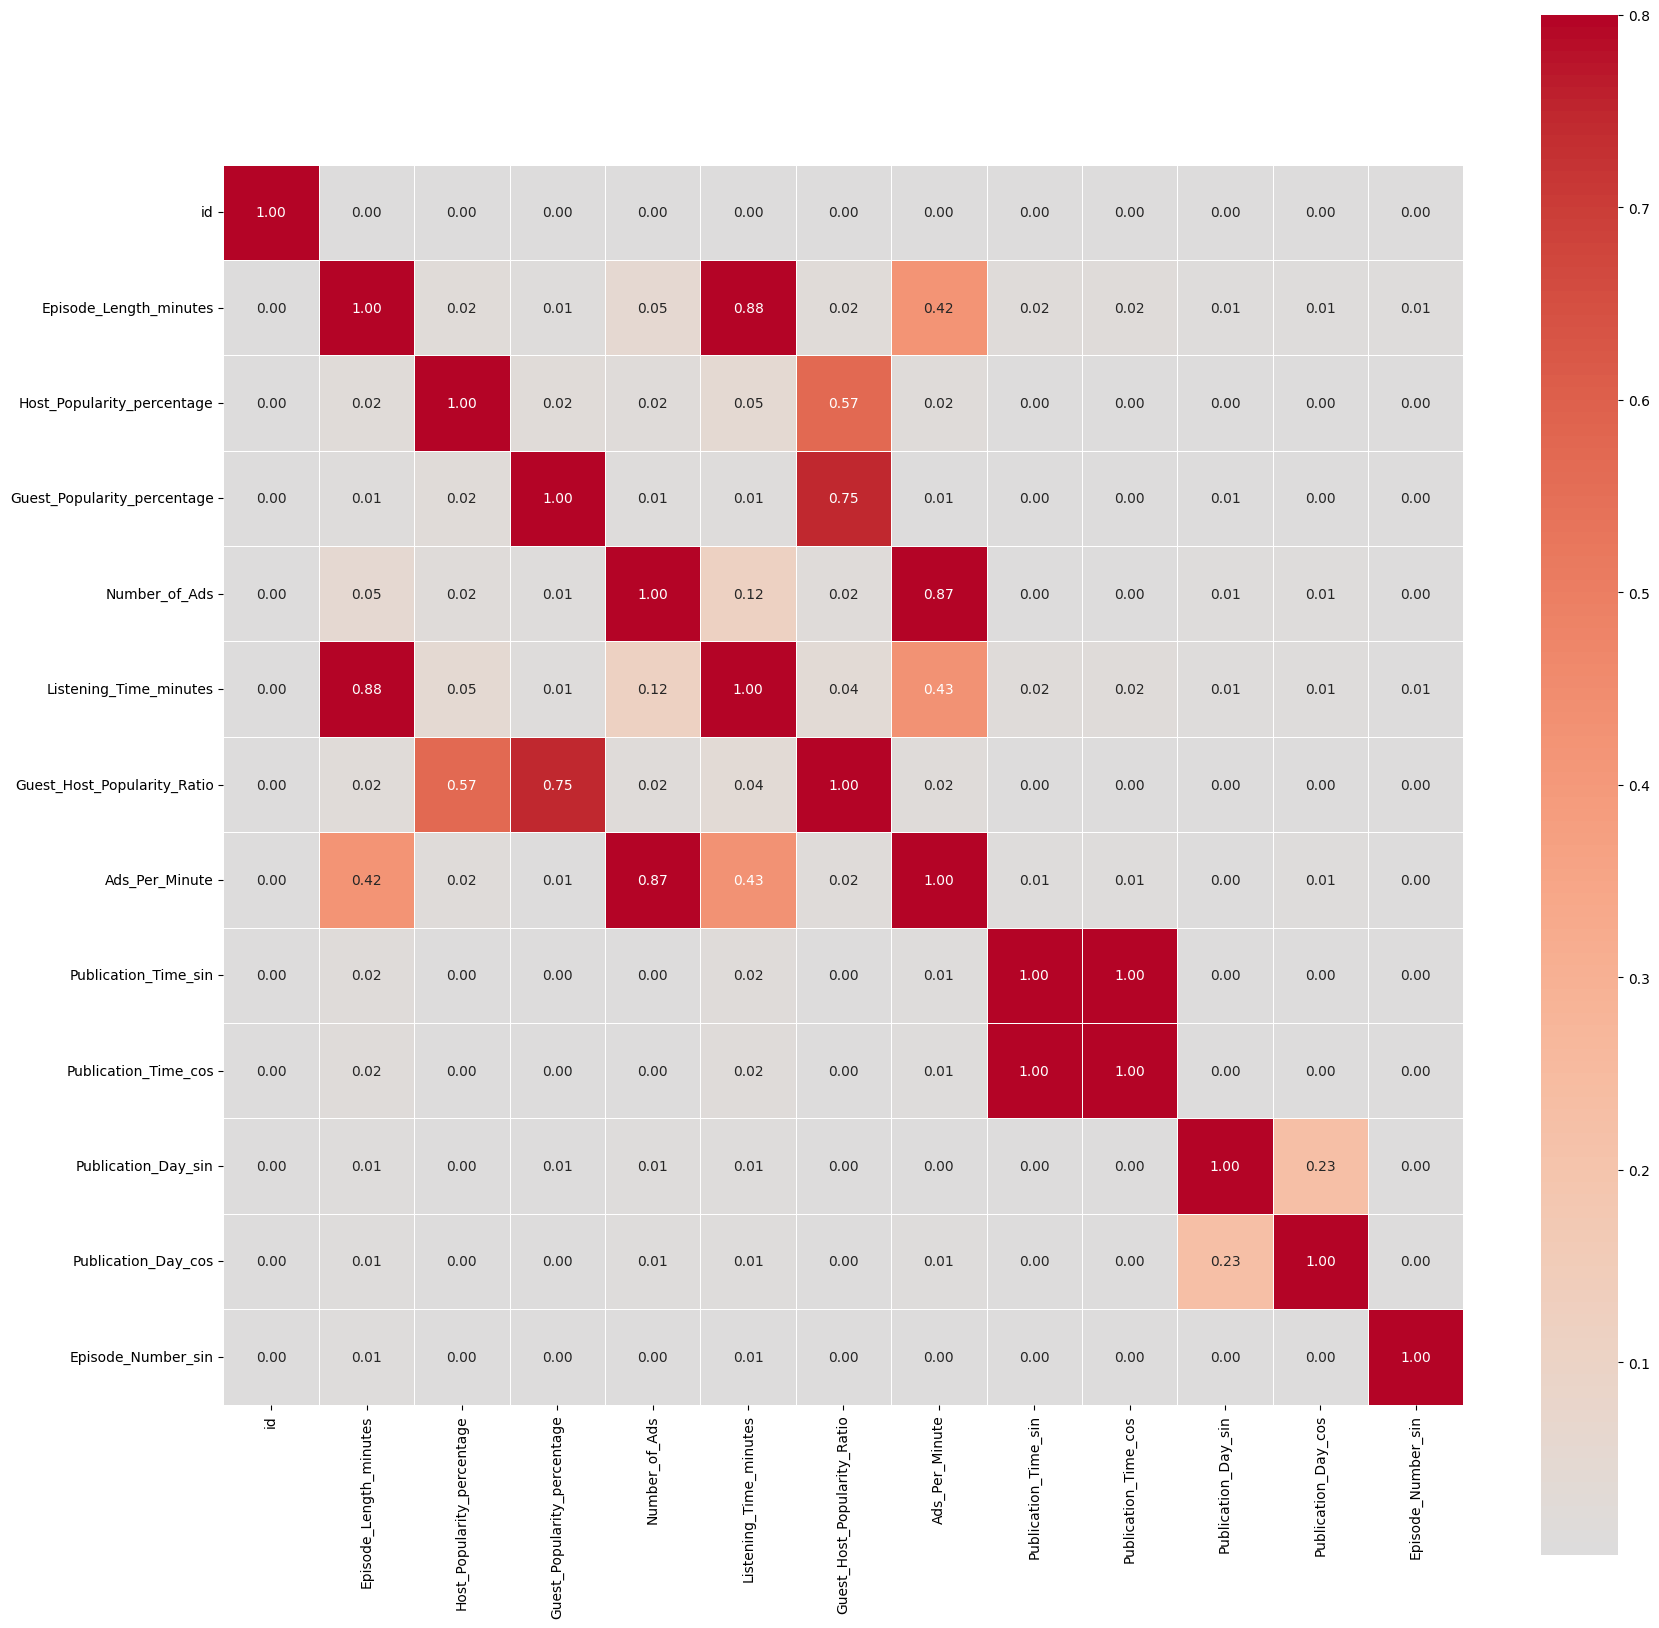

In [22]:
#correlation matrix
corrmat = df_train.select_dtypes(include=['int64', 'float64']).corr(method='spearman').abs()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='coolwarm', annot=True, fmt='.2f', center=0, linewidths=0.5);

## Tree-Based

In [23]:
df_train.dtypes

id                                int64
Podcast_Name                   category
Episode_Length_minutes          float64
Host_Popularity_percentage      float64
Publication_Day                category
Guest_Popularity_percentage     float64
Number_of_Ads                   float64
Listening_Time_minutes          float64
Guest_Host_Popularity_Ratio     float64
Ads_Per_Minute                  float64
Episode_Number                 category
Publication_Time_sin            float64
Publication_Time_cos            float64
Publication_Day_sin             float64
Publication_Day_cos             float64
Episode_Number_sin              float64
Genre_0                            bool
Genre_1                            bool
Genre_2                            bool
Genre_3                            bool
Genre_4                            bool
Genre_5                            bool
Genre_6                            bool
Genre_7                            bool
Genre_8                            bool


In [24]:
X = df_train.drop(columns=['Listening_Time_minutes', 'id']).copy()
y = df_train['Listening_Time_minutes'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit XGBoost model
model = xgb.XGBRegressor(
    max_depth=15,
    n_estimators=1000,
    early_stopping_rounds=100,
    tree_method="gpu_hist",
    enable_categorical=True,
    random_state=1862,
    missing=np.nan,
    eval_metric='rmse',
    device='cuda'
    # gpu_id=0,
    # n_jobs=-1
    )
model.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)], 
            verbose=False)

d:\repositorios_pessoais\podcast-listening-predictor\.venv\lib\site-packages\xgboost\callback.py:386: UserWarning: [13:41:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=100,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

d:\repositorios_pessoais\podcast-listening-predictor\.venv\lib\site-packages\xgboost\sklearn.py:1478: UserWarning: [13:42:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  score = b.get_score(


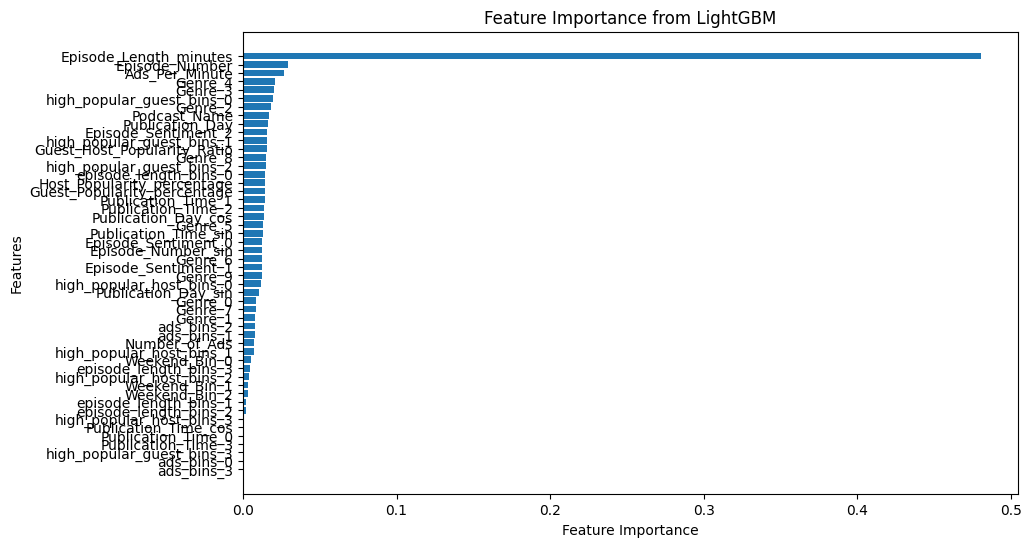

In [25]:
feature_importances = model.feature_importances_
feature_names = X.columns

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

importances_df = importances_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from XGBoost")
plt.gca().invert_yaxis()
plt.show()

In [26]:
features_important = list(importances_df.sort_values(by=['importance'], ascending=False)['feature'].values[:20])
features_important.append('id')
features_important

['Episode_Length_minutes',
 'Episode_Number',
 'Ads_Per_Minute',
 'Genre_4',
 'Genre_3',
 'high_popular_guest_bins_0',
 'Genre_2',
 'Podcast_Name',
 'Publication_Day',
 'Episode_Sentiment_2',
 'high_popular_guest_bins_1',
 'Guest_Host_Popularity_Ratio',
 'Genre_8',
 'high_popular_guest_bins_2',
 'episode_length_bins_0',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Publication_Time_1',
 'Publication_Time_2',
 'Publication_Day_cos',
 'id']

In [27]:
df_test = df_test[features_important]
features_important.append('Listening_Time_minutes')
df_train = df_train[features_important]

# Model Training

In [28]:

X = df_train.drop(columns=['Listening_Time_minutes', 'id']).copy()
y = df_train['Listening_Time_minutes'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    # For dataset with skewed listening time target
    'max_depth': [15],#[3, 4, 5],              # Balance between complexity and overfitting
    'learning_rate': [0.08],#[0.01, 0.02],       # Good balance for your dataset size
    'n_estimators': [1000],                      # Higher for large dataset
    
    # For handling mixed categorical and numerical features
    # 'min_child_weight': [3, 5, 7, 9, 11],       # Higher to handle missing values robustly
    'subsample': [0.9],#[0.8, 0.9, 1.0],            # Good for large dataset
    'colsample_bytree': [0.8],#[0.6, 0.7, 0.8],     # Handle many dummy variables from encoding
    
    # For regularization
    'gamma': [0.5],#[0.5, 1.0, 1.5],                  # Moderate pruning for podcast feature relationships
    # 'reg_alpha': [0.001, 0.01, 0.1],         # L1 regularization for feature selection
    'reg_lambda': [4]#[1.0, 2.0, 4, 6, 8],         # Standard L2 regularization

}


# Create base model
xgb_model = xgb.XGBRegressor(
    early_stopping_rounds=100,
    tree_method="gpu_hist",
    enable_categorical=True,
    random_state=1862,
    missing=np.nan,
    eval_metric='rmse',
    device='cuda'
    # gpu_id=0,
    # n_jobs=-1
)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)

# Fit Grid Search
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])
# eval_set=[(X_test, y_test)]
# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.4f}")



Fitting 5 folds for each of 1 candidates, totalling 5 fits


d:\repositorios_pessoais\podcast-listening-predictor\.venv\lib\site-packages\xgboost\callback.py:386: UserWarning: [13:52:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:25.48225
[1]	validation_0-rmse:24.02251
[2]	validation_0-rmse:22.71349
[3]	validation_0-rmse:21.53139
[4]	validation_0-rmse:20.49385
[5]	validation_0-rmse:19.55222
[6]	validation_0-rmse:18.73480
[7]	validation_0-rmse:18.01269
[8]	validation_0-rmse:17.36495
[9]	validation_0-rmse:16.80930
[10]	validation_0-rmse:16.32171
[11]	validation_0-rmse:15.88323
[12]	validation_0-rmse:15.50756
[13]	validation_0-rmse:15.16789
[14]	validation_0-rmse:14.88349
[15]	validation_0-rmse:14.63649
[16]	validation_0-rmse:14.42016
[17]	validation_0-rmse:14.23415
[18]	validation_0-rmse:14.06954
[19]	validation_0-rmse:13.92634
[20]	validation_0-rmse:13.80314
[21]	validation_0-rmse:13.69698
[22]	validation_0-rmse:13.60472
[23]	validation_0-rmse:13.52424
[24]	validation_0-rmse:13.45443
[25]	validation_0-rmse:13.39582
[26]	validation_0-rmse:13.33922
[27]	validation_0-rmse:13.28788
[28]	validation_0-rmse:13.24571
[29]	validation_0-rmse:13.21223
[30]	validation_0-rmse:13.18903
[31]	validation_0-

In [30]:

# Train final model with best parameters
best_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    tree_method="gpu_hist",
    enable_categorical=True,
    random_state=1862,
    missing=np.nan,
    eval_metric='rmse',
    device='cuda'
    # gpu_id=0,
    # n_jobs=-1
)
best_model.fit(X, y)

d:\repositorios_pessoais\podcast-listening-predictor\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [13:54:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [31]:
pred = best_model.predict(df_test.drop(columns=['id']))

d:\repositorios_pessoais\podcast-listening-predictor\.venv\lib\site-packages\xgboost\core.py:2676: UserWarning: [14:01:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
d:\repositorios_pessoais\podcast-listening-predictor\.venv\lib\site-packages\xgboost\core.py:729: UserWarning: [14:01:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning wil

In [32]:
submission = pd.DataFrame({
    'id': df_test.id,
    'Listening_Time_minutes': pred
})

# Check for invalid values in predictions
print(f"Min prediction: {submission['Listening_Time_minutes'].min()}")
print(f"Max prediction: {submission['Listening_Time_minutes'].max()}")
print(f"Any NaN values: {submission['Listening_Time_minutes'].isna().sum()}")
# submission['Listening_Time_minutes'] = submission['Listening_Time_minutes'].fillna(submission['Listening_Time_minutes'].median())
# Save the submission file
submission.to_csv(r'data/submission_xgboost_gridsearch_deepth_15.csv', index=False)
print("Submission file created successfully!")

Min prediction: -2.3796958923339844
Max prediction: 123.31788635253906
Any NaN values: 0
Submission file created successfully!


Best parameters: {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 4}

# submission_xgboost_with_better_feature_enginearing.csv
- Score in train data: 13.1032
- Score in kaggle submission: 13.1359

# submission_xgboost_with_only_cat.csv
- Score in train data: 14.2938
- Score in kaggle submission: 14.3309

# submission_xgboost_with_only_cat_dummies
- Score in train data: 14.2960
- Score in kaggle submission: 14.3354

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 4, 'subsample': 0.9}

# submission_xgboost_gridsearch
- Score in train data: 13.1089
- Score in kaggle submission: 13.1592

# submission_xgboost_gridsearch_deepth_15
- Score in train data: 13.0459
- Score in kaggle submission: 12.8563

**This leaderboard is calculated with approximately 20% of the test data. The final results will be based on the other 80%, so the final standings may be different!**